# BAO likelihood DEMO

This notebook shows an example of how to use the BAO likelihood.

**Warning:** in order to use this notebook you need to download the DESI data from **_Insert link to data here_**

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sb

from copy      import deepcopy
from itertools import product
from bios      import read
from tqdm      import tqdm

from cobaya.model import get_model

from theory_code.distance_theory import TheoryCalcs

#Plotting
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import rc

rc('text', usetex=True)
rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 18})

red    = '#8e001c'
yellow = '#ffb302'

sidelegend = {'bbox_to_anchor': (1.04,0.5), 
              'loc': "center left",
              'frameon': False}
bottomlegend = {'bbox_to_anchor': (0.35,-0.2), 
                'loc': "center left",
                'frameon': False,
                'ncols': 3}

# Fiducial and testing options

We fix here some of the settings used to visualize the results of the likelihood model

- fiducial: value of the cosmological parameter
- varpar: parameter over which to run the likelihood

In [2]:
fiducial = {'omegam': 0.2977,
            'H0': 68.51,
            'ombh2': 0.02218}

varpar = {'name': 'omegam',
          'latex': r'$\Omega_{\rm m}$',
          'min': 0.01,
          'max': 0.99, 
          'N': 100}

# Run options

Here we see the different options that need to be set to make the likelihood function.

We see them here as separate, but when running a full sampling, these are handled all together by the `runner.py` script.

In [3]:
info = {}

## Likelihood settings

Here we list the settings required by the SNIa likelihood:

- `path`: the path to the BAO dataset to be used
- `data_format`: 
- `observables`: availavle options are `alphas` to use $\alpha_{\rm iso}$ and $\alpha_{\rm AP}$ as observables, or `distances` to use $D_V/r_{\rm d}$ and $D_H/D_M$. Notice that if `data_format` is set to `SKA`, this option is ignored.

We will use here the DESI data, showing how the code works for both possible observables.

### Using $\alpha_{\rm iso}$ and $\alpha_{\rm AP}$

In [4]:
from likelihood.handler import LikelihoodHandler

like = {'BAO_data': {'path': 'data/DESI_table',
                     'data_format': 'DESI',
                     'observables': 'alphas'}}

LikeSets = LikelihoodHandler(like)
alpha_likelihood = LikeSets.like_dict


LOADING BAO DATA

{'data_format': 'DESI', 'observables': 'alphas', 'path': 'data/DESI_table'}


### Using $D_V/r_{\rm d}$ and $D_H/D_M$

In [5]:
like = {'BAO_data': {'path': 'data/DESI_table',
                     'data_format': 'DESI',
                     'observables': 'distances'}}

LikeSets = LikelihoodHandler(like)
distance_likelihood = LikeSets.like_dict


LOADING BAO DATA

{'data_format': 'DESI', 'observables': 'distances', 'path': 'data/DESI_table'}


## Theory settings

In order to work, the likelihood needs a theoretical code to compute theoretical predictions.

Notice that most the observables for BAO are computed by rescaling the observables by those obtained in a fiducial cosmology.

One option of the theory code, very important for BAO calculations is the `fiducial_path`. This is required to rescale the observables by a fiducial cosmology.

The `fiducial_path` could be a string representing the path were fiducial calculations are store in a DataFrame with columns `z, DV_rd, DH_DM`, or it can be a dictionary of parameters values that the theory code will use to compute the fiducial.

If `fiducial_path` is set to `None`, the theory code will use the Planck 2018 $\Lambda$CDM best fit as a fiducial cosmology

In [6]:
from theory_code.handler import TheoryHandler

theory = {'cosmology': 'Standard',
          'fiducial_path': None,
          'DDR_options': None}

info['theory'] = TheoryHandler(theory).theory_dict

## Parameter settings

When launching the likelihood, we need to know which parameters are free to vary and which we are fixed. We load this information from one of the default settings files, a $\Lambda$CDM parameterization.

An important feature must be pointed out here: BAO data alone do not provide constraints on Hubble constant $H_0$ and the sound horizon $r_{\rm d}$, but rather on their combination $H_0\,r_{\rm d}$. If one wants to disentangle this degeneracy, a prior on the baryon density $\Omega_b\,h^2$ must be provided, e.g. from BBN.

Here we include such an information as a Gaussian prior over $\Omega_b\,h^2$. Further down the notebook, we will show how one can work more efficiently when this prior is not included.

In [7]:
preinfo = read('settings/standard/DESI.yaml')

info['params'] = preinfo['params']
print(info['params'])

{'omegam': {'latex': '\\Omega_\\mathrm{m}', 'prior': {'min': 0.001, 'max': 0.99}, 'proposal': 0.05, 'ref': {'dist': 'norm', 'loc': 0.3, 'scale': 0.01}, 'drop': True}, 'omch2': {'value': 'lambda omegam, ombh2, omnuh2, H0: omegam*(H0/100)**2-ombh2-omnuh2', 'latex': '\\Omega_\\mathrm{c} h^2'}, 'ombh2': {'latex': '\\Omega_\\mathrm{b} h^2', 'prior': {'dist': 'norm', 'loc': 0.02218, 'scale': 0.00055}, 'proposal': 0.0001, 'ref': {'dist': 'norm', 'loc': 0.0222, 'scale': 0.0001}}, 'H0': {'latex': 'H_0', 'prior': {'max': 100.0, 'min': 20.0}, 'proposal': 0.5, 'ref': {'dist': 'norm', 'loc': 67.0, 'scale': 0.5}}, 'MB': -19.2435, 'omk': 0.0, 'w': -1.0, 'wa': 0.0, 'omnuh2': 0.0006442, 'nnu': 3, 'rdrag': {'latex': 'r_\\mathrm{d}', 'derived': True}, 'omegaL': {'latex': '\\Omega_\\Lambda', 'derived': True}}


# Exploring the likelihood

We exploit the Cobaya class `get_model` to access the calculations of the likelihood module.

This is not the pipeline used when doing actual runs, but it allows us to look at the different parts of the likelihood

## Alpha likelihood

In [8]:
alpha_model    = get_model(info|{'likelihood': alpha_likelihood})

### Fiducial calculations

We can make the code run end-to-end at a specific point, e.g. the fiducial, to compute the value of the posterior and even accessing the theoretical calculations for that point

In [9]:
logpost_fid_alpha = alpha_model.logposterior(fiducial)
print('')
print('Alpha likelihood')
print(logpost_fid_alpha)


Alpha likelihood
LogPosterior(logpost=-3.1193536651274743, logpriors=[2.2156880592186283], loglikes=array([-5.33504172]), derived=[0.11690487037700002, 148.36510394787106, 0.702223555814618], finite=False)


### Visualize data and theory

We can retrieve both the data and the theory used in the calculations

In [10]:
zvec    = alpha_model.likelihood['BAOlike'].z_vec
datavec = alpha_model.likelihood['BAOlike'].datavectors
covmats = [np.linalg.inv(invcovmat) for invcovmat in alpha_model.likelihood['BAOlike'].inv_covmats]

dataset = pd.DataFrame({'z': zvec})
dataset['alpha_iso'] = [d[0] for d in datavec]
dataset['alpha_AP']  = [d[1] for d in datavec]

dataset['alpha_iso_err'] = [np.sqrt(np.diag(covmat))[0] for covmat in covmats]
dataset['alpha_AP_err'] = [np.sqrt(np.diag(covmat))[1] for covmat in covmats]

print(dataset)

       z  alpha_iso  alpha_AP  alpha_iso_err  alpha_AP_err
0  0.510     0.9911    0.9555       0.007714      0.026130
1  0.706     0.9749    0.9842       0.006705      0.022688
2  0.934     0.9886    1.0237       0.004549      0.015640
3  1.321     0.9911    1.0257       0.007114      0.023646
4  1.484     1.0032    0.9885       0.015342      0.056240
5  2.330     0.9971    1.0071       0.008184      0.021590


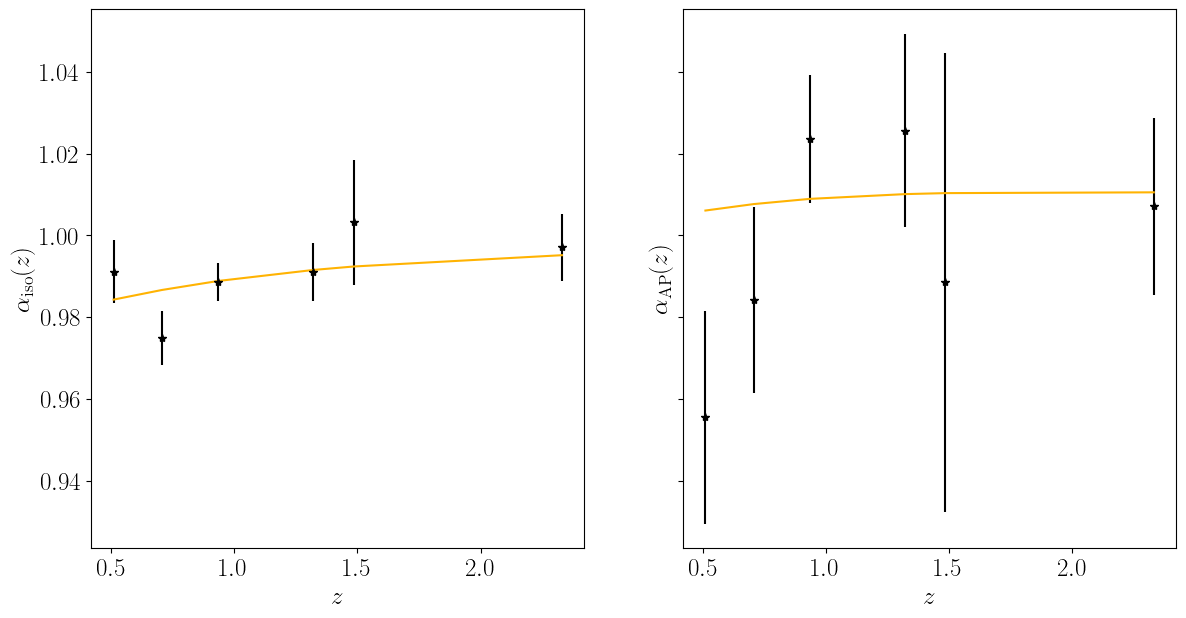

In [11]:
fig,axes = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(14,7))

axes[0].errorbar(dataset['z'],dataset['alpha_iso'],yerr=dataset['alpha_iso_err'],color='black',ls='',marker='*')
axes[0].plot(dataset['z'],alpha_model.provider.get_result('alpha_iso')(dataset['z']),color=yellow)
axes[0].set_xlabel(r'$z$')
axes[0].set_ylabel(r'$\alpha_{\rm iso}(z)$')

axes[1].errorbar(dataset['z'],dataset['alpha_AP'],yerr=dataset['alpha_AP_err'],color='black',ls='',marker='*')
axes[1].plot(dataset['z'],alpha_model.provider.get_result('alpha_AP')(dataset['z']),color=yellow)
axes[1].set_xlabel(r'$z$')
axes[1].set_ylabel(r'$\alpha_{\rm AP}(z)$');

### Computing the posterior on a grid

As a quick check, we can sample the posterior over a grid for a single parameter (the varpar variable chosen at the beginning), while keeping all others fixed at their fiducial values.

In [12]:
par_vals = np.linspace(varpar['min'],varpar['max'],varpar['N'])

chi2s = [pd.DataFrame({varpar['name']: fiducial[varpar['name']],
                       'chi2': -2*logpost_fid_alpha.logpost},index=[0])]
for val in tqdm(par_vals):
    varpoint = deepcopy(fiducial)
    varpoint[varpar['name']] = val
    logpost = alpha_model.logposterior(varpoint)
    chi2s.append(pd.DataFrame({varpar['name']: val,
                               'chi2': -2*logpost.logpost},index=[0]))

chi2_alpha = pd.concat(chi2s,ignore_index=True)


00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.82it/s]

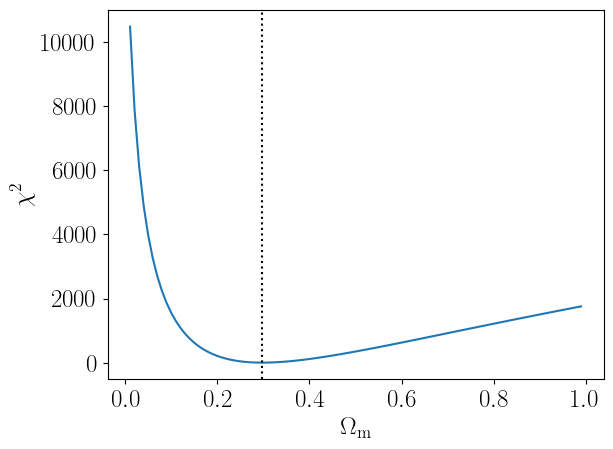

In [13]:
plt.figure()
sb.lineplot(chi2_alpha,x=varpar['name'],y='chi2')
plt.axvline(x=fiducial[varpar['name']],ls=':',color='black')
plt.xlabel(varpar['latex'])
plt.ylabel(r'$\chi^2$');

## Distance likelihood

We now do the same as above with the observables being the distances

In [14]:
distance_model = get_model(info|{'likelihood': distance_likelihood})

### Fiducial calculations

In [15]:
logpost_fid_distance = distance_model.logposterior(fiducial)
print('')
print('Distance likelihood')
print(logpost_fid_distance)


Distance likelihood
LogPosterior(logpost=-3.1266991667743502, logpriors=[2.2156880592186283], loglikes=array([-5.34238723]), derived=[0.11690487037700002, 148.36510394787106, 0.702223555814618], finite=False)


### Visualize data and theory

In [16]:
zvec    = distance_model.likelihood['BAOlike'].z_vec
datavec = distance_model.likelihood['BAOlike'].datavectors
covmats = [np.linalg.inv(invcovmat) for invcovmat in distance_model.likelihood['BAOlike'].inv_covmats]

dataset = pd.DataFrame({'z': zvec})
dataset['DV_rd'] = [d[0] for d in datavec]
dataset['DM_DH']  = [d[1] for d in datavec]

dataset['DV_rd_err'] = [np.sqrt(np.diag(covmat))[0] for covmat in covmats]
dataset['DM_DH_err'] = [np.sqrt(np.diag(covmat))[1] for covmat in covmats]

print(dataset)

       z   DV_rd  DM_DH  DV_rd_err  DM_DH_err
0  0.510  12.720  0.622      0.099      0.017
1  0.706  16.050  0.892      0.110      0.021
2  0.934  19.721  1.223      0.091      0.019
3  1.321  24.252  1.948      0.174      0.045
4  1.484  26.055  2.386      0.398      0.136
5  2.330  31.267  4.518      0.256      0.097


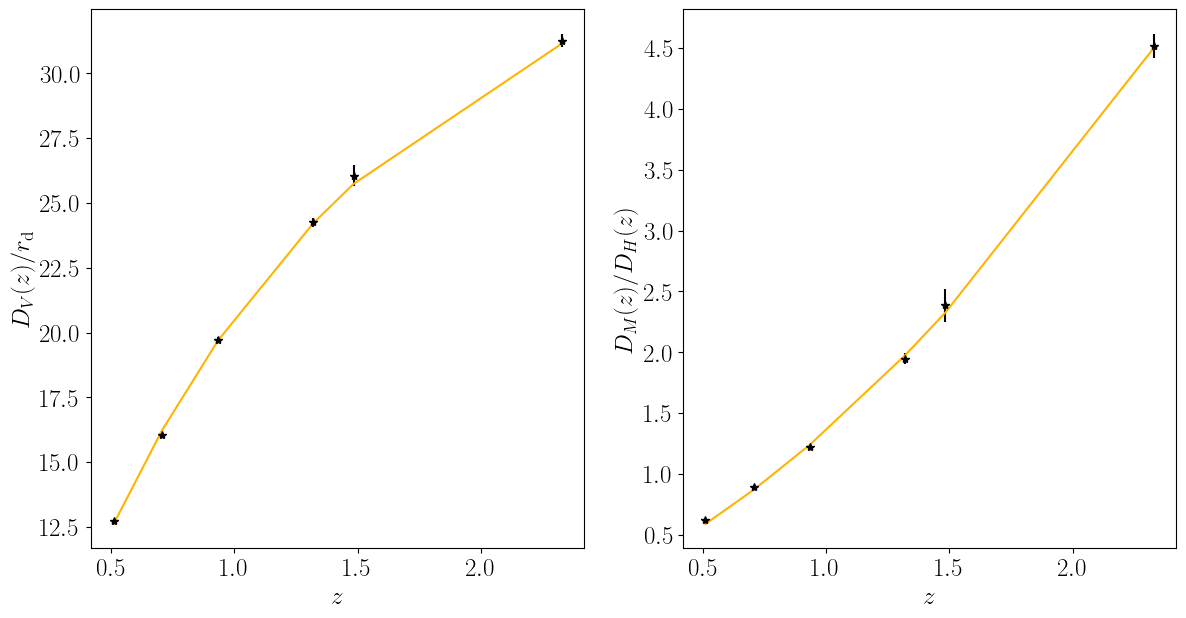

In [17]:
fig,axes = plt.subplots(nrows=1,ncols=2,sharey=False,figsize=(14,7))

axes[0].errorbar(dataset['z'],dataset['DV_rd'],yerr=dataset['DV_rd_err'],color='black',ls='',marker='*')
axes[0].plot(dataset['z'],distance_model.provider.get_result('DV_rd')(dataset['z']),color=yellow)
axes[0].set_xlabel(r'$z$')
axes[0].set_ylabel(r'$D_V(z)/r_{\rm d}$')

axes[1].errorbar(dataset['z'],dataset['DM_DH'],yerr=dataset['DM_DH_err'],color='black',ls='',marker='*')
axes[1].plot(dataset['z'],distance_model.provider.get_result('DM_DH')(dataset['z']),color=yellow)
axes[1].set_xlabel(r'$z$')
axes[1].set_ylabel(r'$D_M(z)/D_H(z)$');

### Computing the posterior on a grid

In [18]:
par_vals = np.linspace(varpar['min'],varpar['max'],varpar['N'])

chi2s = [pd.DataFrame({varpar['name']: fiducial[varpar['name']],
                       'chi2': -2*logpost_fid_distance.logpost},index=[0])]
for val in tqdm(par_vals):
    varpoint = deepcopy(fiducial)
    varpoint[varpar['name']] = val
    logpost = distance_model.logposterior(varpoint)
    chi2s.append(pd.DataFrame({varpar['name']: val,
                               'chi2': -2*logpost.logpost},index=[0]))

chi2_distance = pd.concat(chi2s,ignore_index=True)


00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.49it/s]

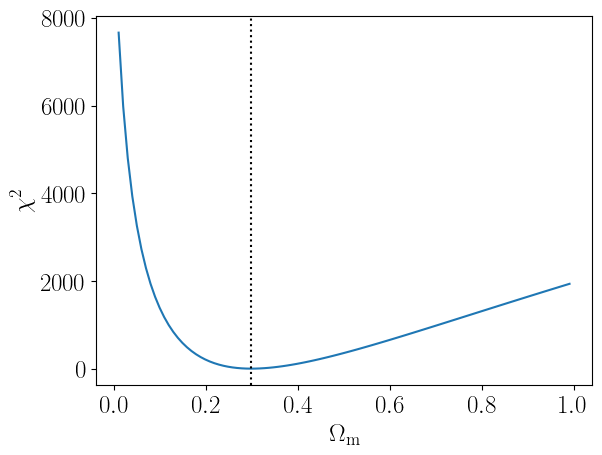

In [19]:
plt.figure()
sb.lineplot(chi2_distance,x=varpar['name'],y='chi2')
plt.axvline(x=fiducial[varpar['name']],ls=':',color='black')
plt.xlabel(varpar['latex'])
plt.ylabel(r'$\chi^2$');

## Likelihood comparison

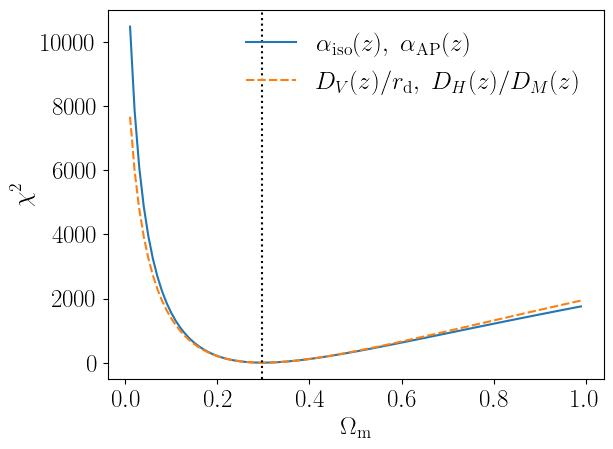

In [20]:
chi2_distance['Observables'] = r'$D_V(z)/r_{\rm d},\ D_H(z)/D_M(z)$'
chi2_alpha['Observables']    = r'$\alpha_{\rm iso}(z),\ \alpha_{\rm AP}(z)$'

chi2 = pd.concat([chi2_alpha,chi2_distance],ignore_index=True)

plt.figure()
sb.lineplot(chi2,x=varpar['name'],y='chi2',hue='Observables',style='Observables')
plt.axvline(x=fiducial[varpar['name']],ls=':',color='black')
plt.xlabel(varpar['latex'])
plt.ylabel(r'$\chi^2$')
plt.legend(loc='best',frameon=False);

# Sampling the posterior

Up to this point, we gave the code no instructions on how to sample the parameter space and reconstruct the posterior, except for when we computed it on a grid.

Below, we see how the sampling work, also making some example on the usage of the SN calibration option.

**WARNING: running this part of the notebook might require some time**

## Sampling settings

This code has a working interface with Cobaya, and therefore it can use all the samplers available for that code. In addition to this, it is also possible to use nested sampling through the Nautilus sampler.

The code requires information on the sampler to be provided with a dictionary with entries:
- `name`: specifying the sampler to be used (`mcmc`, `minimize`, `evaluate`, `nautilus`). The first three coincide with the samplers used by Cobaya, while the latter allows to switch to Nautilus;
- `options`: a dictionary containing the options suitable for the chosen sampler. Notice that, in case Nautilus is chosen, two sets of options are easily available in the code. Choosing `option`: `poor` runs Nautilus with options suitable for a quick test, while `options`: `good` runs it with more precise settings

In [21]:
from samplers.handler import SamplingHandler

### Example 1: minimization

With these settings, the code searches for the peak of the posterior using Cobaya

In [22]:
sampinfo = {'sampler': {'name': 'minimize',
                        'options': None}}

sampler = SamplingHandler(sampinfo)
info['sampler'] = sampler.sampling_dictionary

Running with Metropolis-Hastings


In [23]:
print('')
print('Alpha likelihood')
print('')
alpha_updated_info,alpha_minimum = sampler.run(info|{'likelihood': alpha_likelihood})
print('')
print('Distance likelihood')
print('')
distance_updated_info,distance_minimum = sampler.run(info|{'likelihood': distance_likelihood})


Alpha likelihood

[minimize] Initializing
[minimize] Run 1/2 will start from random initial point:
[minimize] {'omegam': 0.300079355229144, 'ombh2': 0.02223980969271861, 'H0': 67.24212911030946}
[minimize] Run 2/2 will start from random initial point:
[minimize] {'omegam': 0.2829226931058305, 'ombh2': 0.022416506695847955, 'H0': 67.36067564523228}
[prior] *WARNING* There are unbounded parameters (['ombh2']). Prior bounds are given at 0.9999995 confidence level. Beware of likelihood modes at the edge of the prior
[minimize] Starting run 1/2
[minimize] Run 1/2 converged.
[minimize] Starting run 2/2
[minimize] Run 2/2 converged.
[minimize] Finished successfully!
[minimize] -log(posterior) minimized to 3.12635
[minimize] Parameter values at minimum:
   weight  minuslogpost    omegam    ombh2         H0     omch2       rdrag    omegaL  minuslogprior  minuslogprior__0       chi2  chi2__BAOlike
0     1.0      3.126346  0.296551  0.02222  68.536424  0.116433  148.448169  0.703372      -2.2131

### Example 2: nested sampling

with these settings we reconstruct the posterior

In [24]:
sampinfo = {'sampler': {'name': 'nautilus',
                        'options': 'poor'}}

sampler = SamplingHandler(sampinfo)
info['sampler'] = sampler.sampling_dictionary

Running with Nautilus


In [25]:
print('')
print('Alpha likelihood')
print('')
alpha_chain,alpha_nautilus_dict = sampler.run(info|{'likelihood': alpha_likelihood})
print('')
print('Distance likelihood')
print('')
distance_chain,distance_nautilus_dict = sampler.run(info|{'likelihood': distance_likelihood})


Alpha likelihood


RUNNING WITH NAUTILUS SAMPLER

Loading model wrapper of Cobaya
[model] *WARNING* Ignored blocks/options: ['sampler']
model loaded
Preparing the prior...
Loaded prior into Nautilus with dimension 3
Prior keys:  ['omegam', 'ombh2', 'H0']
Starting to sample with Nautilus...
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 18     | 1        | 2        | 16384    | N/A    | 10018 | -13.62   
NAUTILUS SAMPLING FINISHED

Distance likelihood


RUNNING WITH NAUTILUS SAMPLER

Loading model wrapper of Cobaya
[model] *WARNING* Ignored blocks/options: ['sampler']
model loaded
Preparing the prior...
Loaded prior into Nautilus with dimension 3
Prior keys:  ['omegam', 'ombh2', 'H0']
Starting to sample with Nautilus...
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | C

### Plotting

Below a simple function to analyze the output of the tests above. A more sophisticated class to analyze data is available, still linked to getdist, but for a description of that see **_ADD DEMO PLOTTING_**

In [26]:
from getdist import MCSamples,plots

def get_sample(chain,params):

    sample = MCSamples(samples=chain[list(params.keys())].values,names=list(params.keys()),labels=list(params.values()))
    
    return sample

In [27]:
alpha_BBN_sample    = get_sample(alpha_chain,alpha_nautilus_dict)
distance_BBN_sample = get_sample(distance_chain,distance_nautilus_dict)

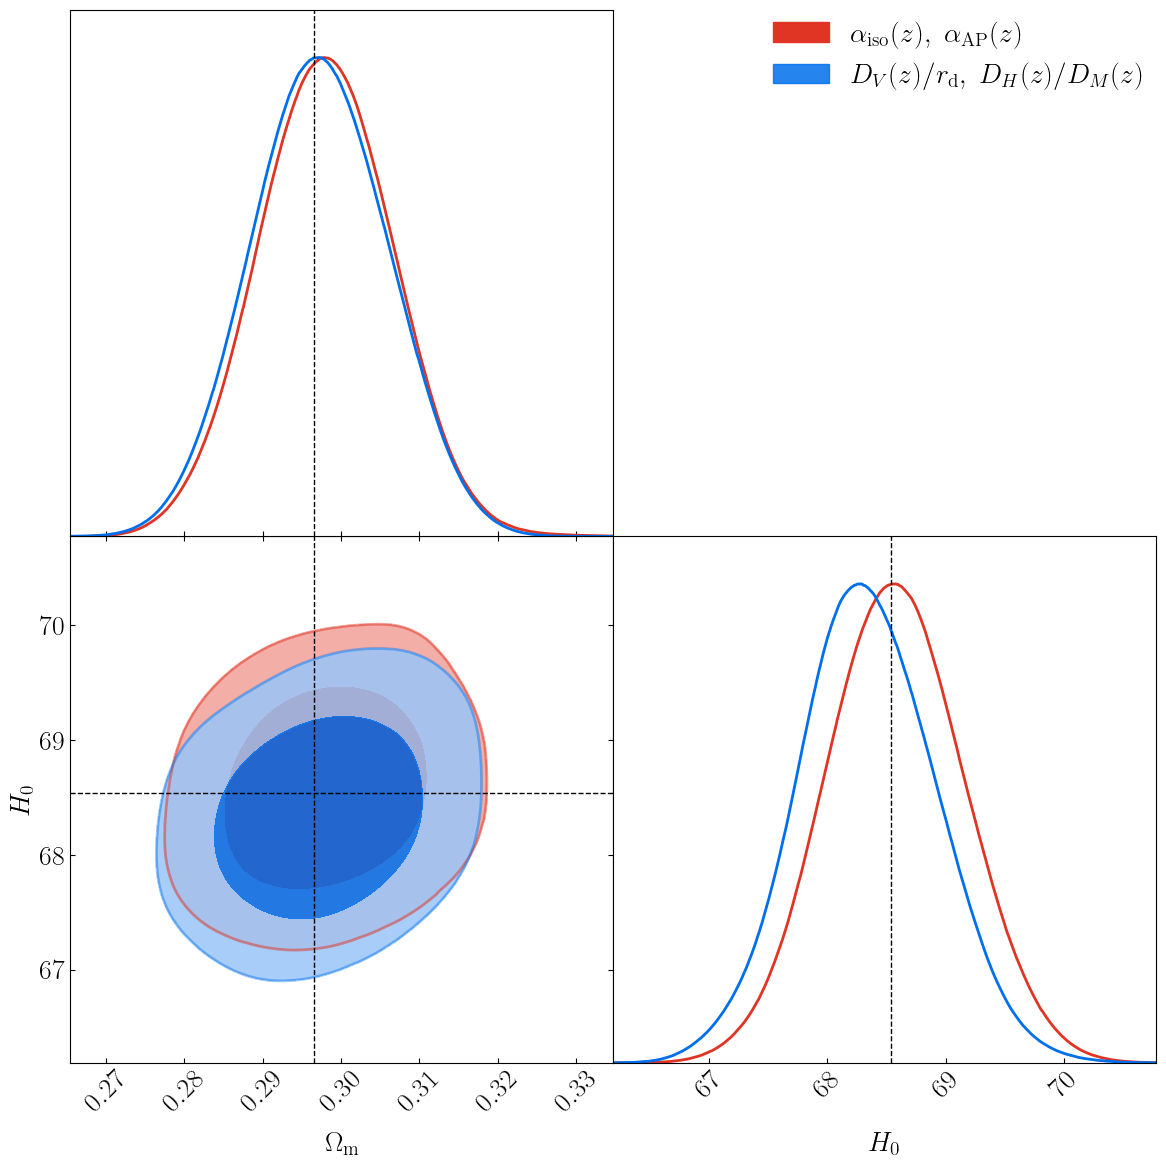

In [28]:
params = ['omegam','H0']

g = plots.get_subplot_plotter(subplot_size=1,width_inch=12, scaling=False)
g.settings.figure_legend_frame = False
g.settings.axes_fontsize=20
g.settings.axes_labelsize=20
g.settings.legend_fontsize=20
g.settings.axis_marker_color = 'black'
g.settings.axis_marker_ls = '--'
g.settings.axis_marker_lw = 1
g.settings.axis_tick_x_rotation = 45
g.triangle_plot([alpha_BBN_sample,distance_BBN_sample], params,
    filled=True,
    legend_loc='upper right',
    legend_labels=[r'$\alpha_{\rm iso}(z),\ \alpha_{\rm AP}(z)$',r'$D_V(z)/r_{\rm d},\ D_H(z)/D_M(z)$'],
    contour_lws=2,
    markers={par: alpha_minimum.minimum[par] for par in params})
g.fig.align_ylabels()
g.fig.align_xlabels();

## Running without BBN prior

...blablabla...

### BBN samples

We add $h*r_{\rm d}$ as a derived parameter to the results above, so we can compare with the no BBN case

In [30]:
cases = {'DESI+BBN (alphas)': {'sample': alpha_BBN_sample,
                               'color': 'blue',
                               'filled': True},
         'DESI+BBN (distances)': {'sample': distance_BBN_sample,
                                  'color': 'red',
                                  'filled': True}}

for name,case in cases.items():
    temp = case['sample']
    p = temp.getParams()
    temp.addDerived(p.rdrag*p.H0/100, name="h_rdrag", label="h\,r_\mathrm{d}")
    case['sample'] = temp

### No BBN prior


Without such a prior, sampling over $H_0$ and $\Omega_b\,h^2$ is pretty useless, and it might slow done the sampling convergence. This can be avoided by switching the sampling from $\Omega_b,h^2$...

In [31]:
info['params'] = {'omegam': {'latex': '\Omega_\mathrm{m}',
                             'prior': {'min': 0.001,'max': 0.99},
                             'drop': True},
                  'omch2': {'value': "lambda omegam, ombh2, omnuh2, H0: omegam*(H0/100)**2-ombh2-omnuh2",
                            'latex': '\Omega_\mathrm{c} h^2'},
                  'ombh2': 0.02218,
                  'omnuh2': 0.00064420,
                  'omk': 0.,
                  'MB': -19.2435,
                  'w': -1.,
                  'wa': 0.,
                  'nnu': 3.,
                  'H0': {'latex': 'H_0',
                         'prior': {'max': 100.0,'min': 20.0}},
                  'rd': {'latex': 'r_\mathrm{d}',
                         'prior': {'max': 200,'min': 100}},
                  'h_rdrag': {'derived': "lambda H0,rd: H0*rd/100",
                              'latex': 'h\,r_\mathrm{d}'},
                  'rdrag': {'latex': 'r_\mathrm{d}',
                            'derived': True},
                  'omegaL': {'latex': '\Omega_\Lambda',
                             'derived': True}}

In [32]:
print('')
print('Alpha likelihood')
print('')
alpha_chain,alpha_nautilus_dict = sampler.run(info|{'likelihood': alpha_likelihood})
print('')
print('Distance likelihood')
print('')
distance_chain,distance_nautilus_dict = sampler.run(info|{'likelihood': distance_likelihood})


Alpha likelihood


RUNNING WITH NAUTILUS SAMPLER

Loading model wrapper of Cobaya
[model] *WARNING* Ignored blocks/options: ['sampler']
[parameterization] *WARNING* There are repeated parameter labels: {'r_\\mathrm{d}': ['rd', 'rdrag']}
model loaded
Preparing the prior...
Loaded prior into Nautilus with dimension 3
Prior keys:  ['omegam', 'H0', 'rd']
Starting to sample with Nautilus...
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 19     | 2        | 2        | 19520    | N/A    | 10052 | -14.32   
NAUTILUS SAMPLING FINISHED

Distance likelihood


RUNNING WITH NAUTILUS SAMPLER

Loading model wrapper of Cobaya
[model] *WARNING* Ignored blocks/options: ['sampler']
[parameterization] *WARNING* There are repeated parameter labels: {'r_\\mathrm{d}': ['rd', 'rdrag']}
model loaded
Preparing the prior...
Loaded prior into Nautilus with dimension 3
Prior keys

In [41]:
cases['DESI (alphas)'] = {'sample': get_sample(alpha_chain,alpha_nautilus_dict),
                          'color': 'blue',
                          'filled': False}
cases['DESI (distances)'] = {'sample': get_sample(distance_chain,distance_nautilus_dict),
                             'color': 'red',
                             'filled': False}

{'omegam': '\\Omega_\\mathrm{m}', 'H0': 'H_0', 'rd': 'r_\\mathrm{d}', 'omch2': '\\Omega_\\mathrm{c} h^2', 'h_rdrag': 'h\\,r_\\mathrm{d}', 'rdrag': 'r_\\mathrm{d}', 'omegaL': '\\Omega_\\Lambda'}


### Plotting comparison

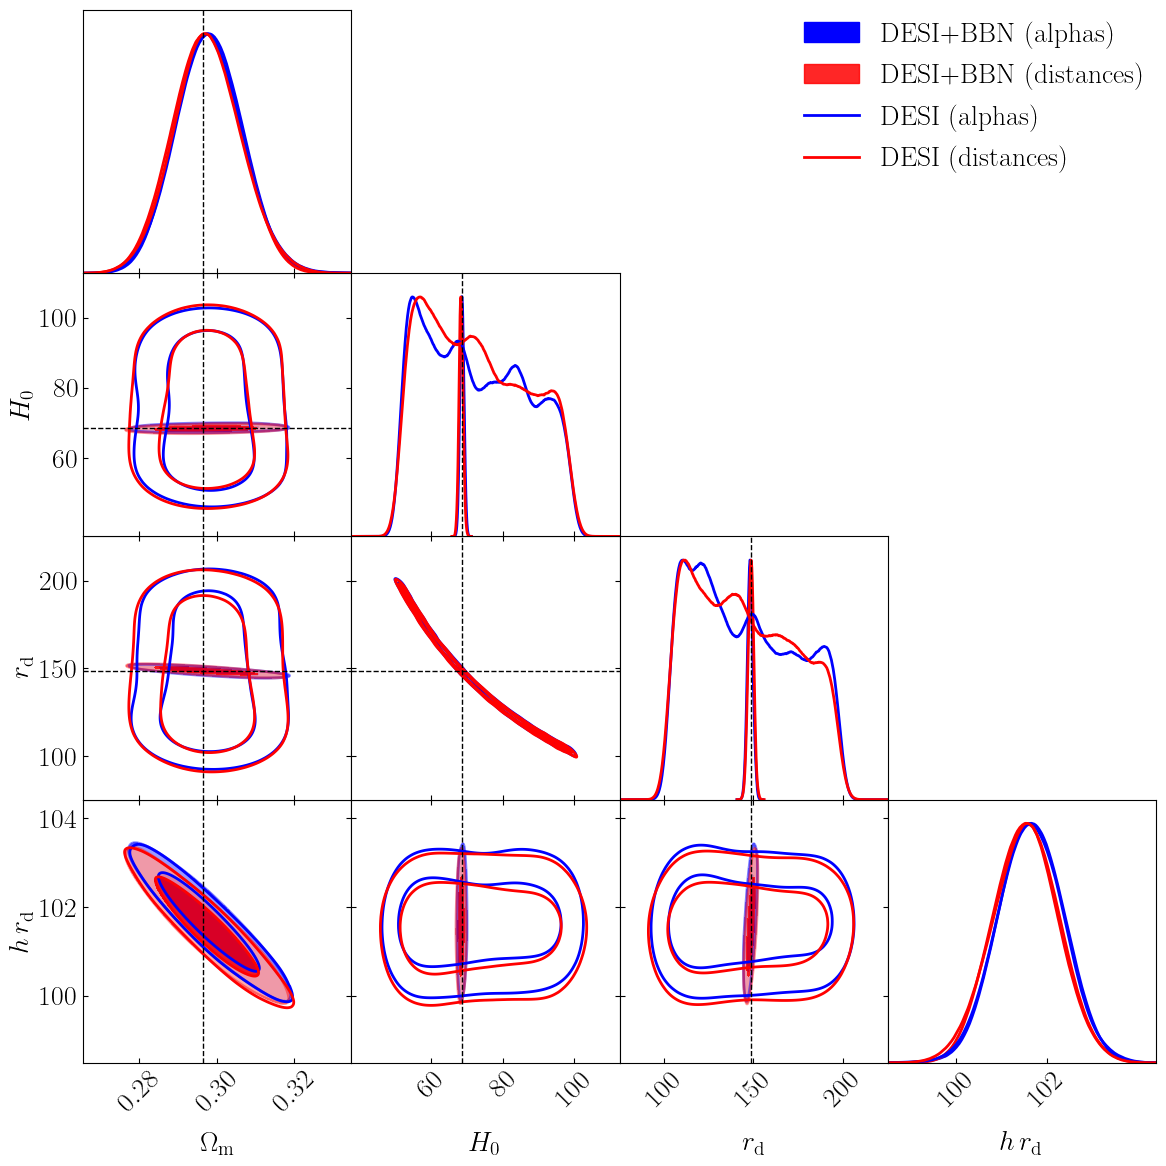

In [45]:
params = ['omegam','H0','rdrag','h_rdrag']

g = plots.get_subplot_plotter(subplot_size=1,width_inch=12, scaling=False)
g.settings.figure_legend_frame = False
g.settings.axes_fontsize=20
g.settings.axes_labelsize=20
g.settings.legend_fontsize=20
g.settings.axis_marker_color = 'black'
g.settings.axis_marker_ls = '--'
g.settings.axis_marker_lw = 1
g.settings.axis_tick_x_rotation = 45
g.triangle_plot([case['sample'] for case in cases.values()], params,
    filled=[case['filled'] for case in cases.values()],
    legend_loc='upper right',
    legend_labels=[case for case in cases.keys()],
    contour_colors=[case['color'] for case in cases.values()],
    contour_lws=2,
    markers={par: alpha_minimum.minimum[par] for par in params if par != 'h_rdrag'})
g.fig.align_ylabels()
g.fig.align_xlabels();